<a href="https://colab.research.google.com/github/Asura3301/makemore/blob/main/build_makemore_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We implement a multilayer perceptron (MLP) character-level language model.

Main reference paper - [A Neural Probabilistic Language Model | Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

Additional materials:
- PyTorch Internals https://blog.ezyang.com/2019/05/pytorch-internals/

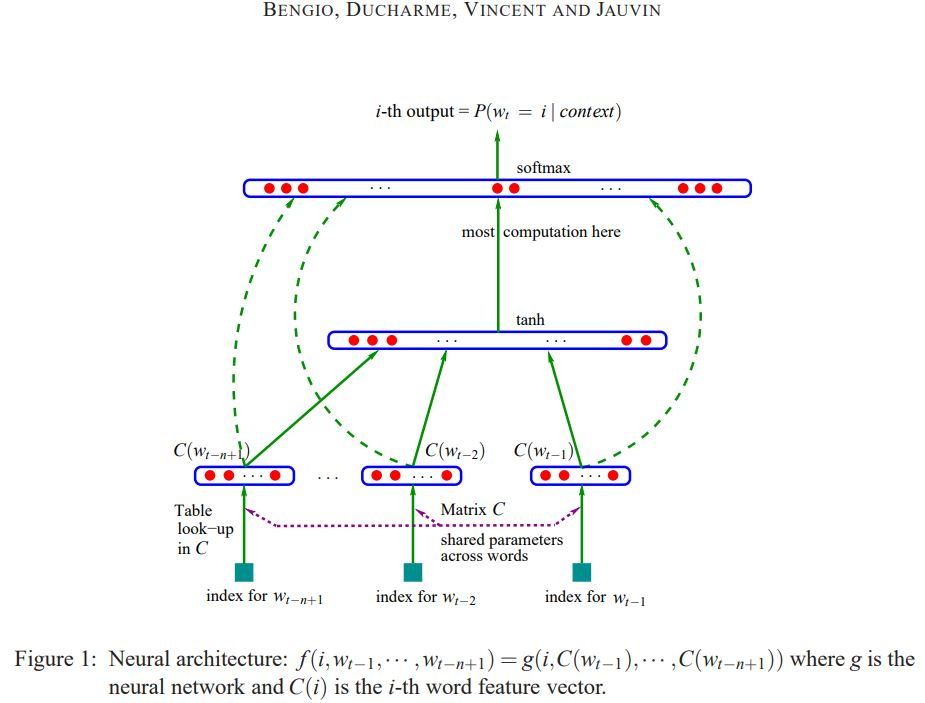

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
# read in all the words
words = open("/content/drive/MyDrive/Colab Notebooks/Projects/makemore/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [70]:
len(words)

32033

In [71]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi["."] = 0 # EOS/SOS
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [106]:
# build the dataset

block_size = 3 # context length:how many characters we take to predict next one?
X, Y = [], []
for w in words:

  # print(w)
  context = [0] * block_size
  for ch in w + ".":
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print("".join(itos[i] for i in context), "--->", itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [99]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [217]:
# build the dataset(train_test_split)

def build_dataset(words):
  block_size = 3 # context length:how many characters we take to predict next one?
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print("".join(itos[i] for i in context), "--->", itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [216]:
# embedding tables
C = torch.randn((27, 2))

In [75]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [76]:
W1 = torch.randn((6, 100)) # 3*2=6 num of inputs and 100 neurons
b1 = torch.randn(100)

In [77]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
# broadcasting tensors (emb.view(-1, 6) @ W1) + (b1)
# [32, 100]
# [ 1, 100]

In [78]:
# "torch.cat" Concatenates the given sequence of tensors in tensors in the given dimension.
# "torch.unbind" Removes a tensor dimension / Returns a tuple of all slices along a given dimension
# torch.cat(torch.unbind(emb, 1), dim=1).shape
# emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), dim=1)

In [79]:
h.shape

torch.Size([32, 100])

In [80]:
W2 = torch.randn((100, 27)) # input 100/ output 27 "characters"
b2 = torch.randn(27)

1) get a logits

2) take a "fake" counts

3) normalize them into probability


In [81]:
# step 1 get logits
logits = h @ W2 + b2

In [82]:
logits.shape

torch.Size([32, 27])

In [83]:
# step 2 take a "fake" counts
counts = logits.exp()

In [84]:
# step 3 normalize counts to give us a probability
prob = counts / counts.sum(1, keepdim=True)
prob[0].sum()

tensor(1.0000)

In [85]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(13.9505)

In [86]:
# -----------------SUMMARIZE-------------------

In [218]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182512, 3]), torch.Size([182512]))

In [274]:
g = torch.Generator().manual_seed(42)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) # 3*10=30 num of inputs and 300 neurons
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) # input 300/ output 27 "characters"
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [275]:
sum(p.nelement() for p in parameters) # num of parameters in total

11897

In [276]:
for p in parameters:
  p.requires_grad = True

In [277]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [278]:
lri = []
lossi = []
stepi = []

In [279]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,), generator=g)

  # forward pass
  emb = C[Xtr[ix]] # embedding of X (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # tanh activasion func (32, 200)
  logits = h @ W2 + b2 # logits(final layer of nn)
  # counts = logits.exp() # fake counts
  # prob = counts / counts.sum(1, keepdim=True) # normalize and get probability
  # loss = -prob[torch.arange(32), Y].log().mean() # loss of model
  loss = F.cross_entropy(logits, Ytr[ix]) # more efficient than above lines, because its not create a new tensors in memory(fused kernel)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)

# print(loss.item())

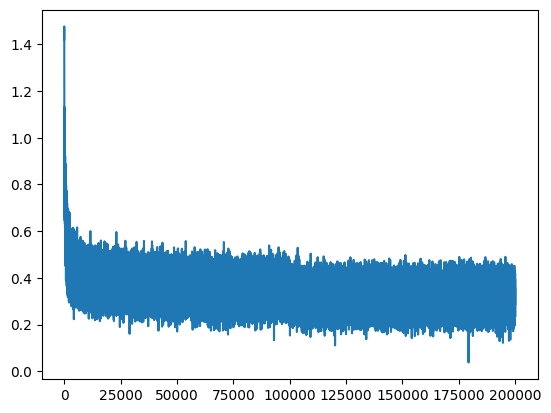

In [280]:
plt.plot(stepi, lossi)
# its very thick because batchsize is very small

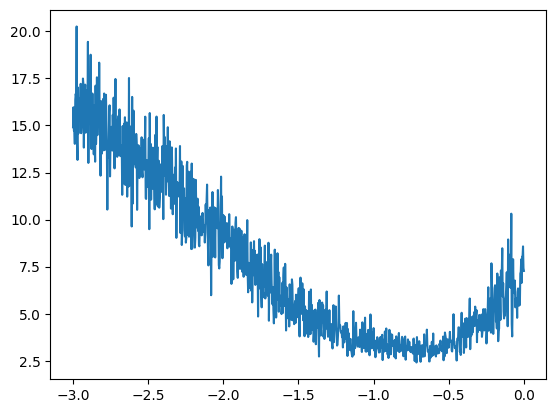

In [163]:
plt.plot(lri, lossi)

Why use minibathes in practical? - its much more better to have an approximate gradient and just make more steps than to evaluate the exact gradient and make fewer steps

In [281]:
# evaluate train set
emb = C[Xtr] # embedding of X (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # tanh activasion func (32, 200)
logits = h @ W2 + b2 # logits(final layer of nn)
loss = F.cross_entropy(logits, Ytr) # more efficient than above lines, because its not create a new tensors in memory(fused kernel)
loss

tensor(2.1222, grad_fn=<NllLossBackward0>)

In [282]:
# evaluate val set
emb = C[Xval] # embedding of X (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # tanh activasion func (32, 200)
logits = h @ W2 + b2 # logits(final layer of nn)
loss = F.cross_entropy(logits, Yval) # more efficient than above lines, because its not create a new tensors in memory(fused kernel)
loss

tensor(2.1735, grad_fn=<NllLossBackward0>)

Some ways to optimizations model perfomance are:
- Continue to play with the size of Neural Net
- Change the number of neurons in the hidden layer of this model
- Change dimensionality of the embedding look-up table "C"
- Change number characters that are feeding as an input as the context into this model
- Change details of the optimization


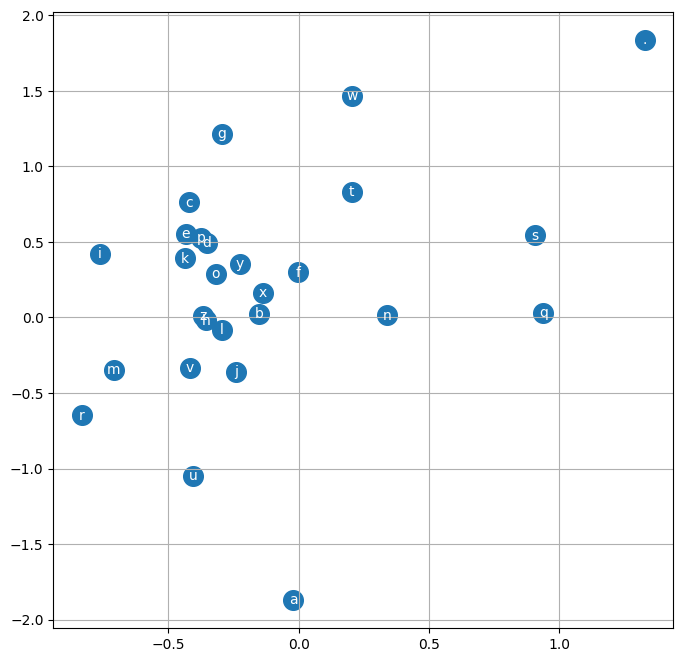

In [283]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [ ]:
# training split | dev/validation split | test split
# 80% / 10% / 10%
# training split - use to optimize parameters of the model
# valid split - used for development over all hyper parameters of the model
# test split - used to evaluate perfomance of the model in the end

In [287]:
# Sample from the model
g = torch.Generator().manual_seed(42)

for i in range(20):

  out = []
  context = [0] * block_size # initialize
  while True:
    emb = C[torch.tensor([context])] # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print("".join(itos[i] for i in out))

yeesyah.
malin.
dleek.
skyng.
nya.
tryah.
arhen.
emberlynn.
ize.
yukeles.
lon.
toy.
joveri.
pepo.
zandzekelsenalauron.
nacella.
adari.
zeriaqute.
shirahmolw.
eiliony.
